<details>
<summary>📓 &nbsp; Modeling Sequential Data Using Recurrent Neural Networks
</summary><br/>Github Links<br/>    
<a href="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch16/ch16_part1.ipynb">Part 1</a><br/>
<a href="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch16/ch16_part2.ipynb">Part 2</a><br/>
</details>

In [1]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Akronim','Smokum',30,15
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' style='font-family:"""+\
    font+"""; color:"""+fontcolor+"""; font-size:"""+\
    str(fontsize)+"""px;'>%s</h1>"""%string))

In [2]:
dhtml('Code Modules, Setting, & Functions')

In [3]:
import numpy as np,pylab as pl
import tensorflow as tf
import tensorflow.keras.layers as tkl
import tensorflow_datasets as tfds
from collections import Counter
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing \
import sequence as tksequence

In [4]:
def get_weights_shape(layer):
    w_xh,w_oo,b_h=layer.weights
    print('w_xh shape: %s'%w_xh.shape)
    print('w_oo shape: %s'%w_oo.shape)
    print('b_h shape: %s'%b_h.shape) 
def compare_calc(layer,x):
    n,inputs=x.shape[0],x.shape[1]
    w_xh,w_oo,b_h=layer.weights
    out_calc=[]
    output=layer(
        tf.reshape(x,shape=(1,n,inputs)))
    pl.figure(figsize=(10,5))
    for t in range(n):
        xt=tf.reshape(x_seq[t],(1,inputs))
        print('time step {} =>'.format(t))
        print(5*' '+'input'+13*' '+': '+
              str(xt.numpy()))
        ht=tf.matmul(xt,w_xh)+b_h 
        print(5*' '+'hidden'+11*' '+': '+   
              str(ht.numpy()))   
        if t>0:
            prev_o=out_calc[t-1]
        else:
            prev_o=tf.zeros(shape=(ht.shape))        
        ot=ht+tf.matmul(prev_o,w_oo)
        ot=tf.math.tanh(ot)
        out_calc.append(ot)
        print(5*' '+'calculated output: '+
              str(ot.numpy()))
        print(5*' '+'SimpleRNN output:   '.format(t)+
              str(output[0][t].numpy())+'\n')
        pl.plot(output[0][t].numpy(),'-o',
                label='time step %d'%t)
    pl.grid(); pl.legend(); pl.show()

In [5]:
def encode(text_tensor,label):
    text=text_tensor.numpy()
    encoded_text=encoder.encode(text)
    return encoded_text,label
def encode_fmap(text,label):
    return tf.py_function(encode,inp=[text,label], 
                          Tout=(tf.int64,tf.int64))

In [6]:
dhtml('Data Exploration')

In [7]:
# 25,000 movies reviews from IMDB, 
# labeled by sentiment (positive/negative)
num_words=10000; max_length=1000
embedding_vector_length=32
(x_train,y_train),(x_test,y_test)=\
imdb.load_data(path="imdb_full.pkl",
               num_words=num_words,
               skip_top=0,seed=113,
               maxlen=max_length,
               start_char=1,oov_char=2,
               index_from=3)

17465344/17464789 [==============================] - 0s 0us/step


In [8]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)
x=np.vstack([x_train.reshape(-1,1),
             x_test.reshape(-1,1)])
y=np.vstack([y_train.reshape(-1,1),
             y_test.reshape(-1,1)])
x=x.reshape(-1); y=y.reshape(-1)
print(x.shape,y.shape)

(24875,) (24944,)
(24875,) (24944,)
(49819,) (49819,)


In [9]:
word_to_id=imdb.get_word_index()
word_to_id=\
{k:(v+3) for k,v in word_to_id.items()}
sw=["<PAD>","<START>","<UNK>","<UNUSED>"]
for i in range(4): word_to_id[sw[i]]=i
id_to_word=\
 {value:key for key,value in word_to_id.items()}
def get_string(x,i):
    return ' '.join(id_to_word[id] for id in x[i] if id>3)

1646592/1641221 [==============================] - 0s 0us/step


In [10]:
features=[get_string(x,i) 
          for i in range(x.shape[0])]
features=np.array(features)
targets=y
dhtml(features[0],c2,f2,fs2)

In [11]:
dhtml('Data Building')

In [12]:
ds=tf.data.Dataset.\
from_tensor_slices((features,targets))
for ex in ds.take(3):
    tf.print(ex[0].numpy()[:60],ex[1])

b'this film was just brilliant casting location scenery story ' 1
b'big hair big boobs bad music and a giant safety pin these ar' 0
b'this has to be one of the worst films of the 1990s when my f' 0


In [13]:
tf.random.set_seed(123)
ds=ds.shuffle(50000,reshuffle_each_iteration=False)
ds_test=ds.take(10000)
ds_train_valid=ds.skip(10000)
ds_valid=ds_train_valid.take(10000)
ds_train=ds_train_valid.skip(10000)

In [14]:
tokenizer=tfds.features.text.Tokenizer()
token_counts=Counter()
for example in ds_train:
    tokens=tokenizer.tokenize(example[0].numpy())
    token_counts.update(tokens)
print('vocabulary size:',len(token_counts))

vocabulary size: 9807


In [15]:
encoder=tfds.features.text\
.TokenTextEncoder(token_counts)
example_str='hi this is an example of sentences'
encoder.encode(example_str)

[4621, 4, 12, 97, 121, 22, 4029]

In [16]:
tf.random.set_seed(123)
train=ds_train.map(encode_fmap)
valid=ds_valid.map(encode_fmap)
test=ds_test.map(encode_fmap)

In [17]:
tf.random.set_seed(1)
for example in train.shuffle(1000).take(3):
    print('sequence length:',example[0].shape)
    print(example[0].numpy())

sequence length: (118,)
[   4    9  318   31  642  464   22 6159   11 5414   22   97 3798 1924
   11 3217   12  529   69 5413   30  211   30 1149 5808 5809 5810   12
  233 1562   30   31  437   69   18    1   86   52  507  117  191   18
  305  113  308  169 6429 4061   31  642  205 1015  525  117 1252   30
   11 6528 2727  438   15   12  837  117 3437  117   56   30  501   22
   57 1785 7082   97 5317  117 1489  329  258   11  764   22   11  428
 2103  246  348   12   31 6209   47 1647  117  772  578   18   52   12
   31 3186 3123  318  194 7965   47   11 5982  362   21  571  117  830
 5203   82   11  348   22  856]
sequence length: (111,)
[4091 1093  201 1997   82   11 7886   15 2619   15 1667  364 1657 1303
   24   57  166 1997   75  195  687  727   31 1997    5   30  649   22
  100  247    4   12   31 1217  332 5330   63  713 7316   82   11 2019
   15 1080    4    9   12 2198 1303 2185 4522  767  253   64   30 7956
   67 6584 1703  602   11    9 5486   47   83 1143  296   15   47   

In [18]:
ds_example=train.take(20)
print('individual sizes:')
for example in ds_example:
    print(example[0].shape)
ds_batched_example=ds_example\
.padded_batch(4,padded_shapes=([-1],[]))
print('batch dimensions:')
for batch in ds_batched_example:
    print(batch[0].shape)

individual sizes:
(283,)
(209,)
(258,)
(216,)
(141,)
(318,)
(187,)
(142,)
(90,)
(141,)
(154,)
(319,)
(806,)
(33,)
(526,)
(146,)
(89,)
(127,)
(172,)
(76,)
batch dimensions:
(4, 283)
(4, 318)
(4, 319)
(4, 806)
(4, 172)


In [19]:
train_data=train.padded_batch(
    32,padded_shapes=([-1],[]))
valid_data=valid.padded_batch(
    32,padded_shapes=([-1],[]))
test_data=test.padded_batch(
    32,padded_shapes=([-1],[]))

In [20]:
for example in train_data.take(1):
    print(example[0].numpy()[0],'\n',
          example[1].numpy())

[  1   2   3   4   5   6   7   8   9  10  11   5  12  13  14  15   1  16
  17  18  19  20  21  22  11  23  24  25  11  26  27  28  29  29  30  31
  32  33  34   1  35  36  13  37  38  18  39  40  41  11  42  22  11  43
  33  11  44  45  11  46  47  48  49  15  50  30   1  51  52  11   5  53
  54  55  15  11  56  22  57  58  59   1  60  61  51  13  52  62  63  31
  64  65  66  67  11  68  69  31  70  71  72  73  15  11  74  75  76  77
  15  78  79   1  80  11   9  81  82  83  84  15  13  11  85   1  86  87
  88  11  89   7  15  11  90  91  22  92  93  94  11  95  22  11  78  47
   4  96   4   5  12  97  98   7  11  22  11  32  33  99  13  11 100  22
  11  32 101  21 102 103 104 105  69 106 107  13   4 108 102 109 110  11
  89   7  11 111 112 113  11 114  82  11  32   9 115  40  62  63  97 116
 117 118 119  11  22  11  32 100 120 121  22   4 122  22   1  86  13 123
 124 125  11  95  22  31 126 127 128  13 129 130 112   1 131 117 132  31
  74   7  52 133 134 135  38 136 117   4 137 138 13

In [21]:
dhtml('Embedding, RNN, LSTM, & GRU Layers')

In [22]:
model=tf.keras.Sequential(
    name='embedding_structure')
model.add(tkl.Embedding(
    input_dim=256,output_dim=5,
    input_length=32,name='embedding_1'))
model.summary()

Model: "embedding_structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 5)             1280      
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
_________________________________________________________________


In [23]:
def rnn_layer(inputs,units):
    rnn_layer=tkl.SimpleRNN(
        units=units,use_bias=True,
        return_sequences=True)
    rnn_layer.build(
        input_shape=(None,None,inputs))
    return rnn_layer

In [24]:
m=5; inputs=7; units=4
tf.random.set_seed(123)
rnn_layer74=rnn_layer(inputs,units)    
get_weights_shape(rnn_layer74)

w_xh shape: (7, 4)
w_oo shape: (4, 4)
b_h shape: (4,)


time step 0 =>
     input             : [[1. 1. 1. 1. 1. 1. 1.]]
     hidden           : [[ 0.01295897  1.2222549   0.32739955 -0.6797645 ]]
     calculated output: [[ 0.01295825  0.8403181   0.31618223 -0.5913663 ]]
     SimpleRNN output:   [ 0.01295825  0.8403181   0.31618223 -0.5913663 ]

time step 1 =>
     input             : [[2. 2. 2. 2. 2. 2. 2.]]
     hidden           : [[ 0.02591795  2.4445097   0.6547991  -1.359529  ]]
     calculated output: [[ 0.20680074  0.9325751   0.5290113  -0.9697159 ]]
     SimpleRNN output:   [ 0.20680074  0.9325751   0.5290113  -0.9697159 ]

time step 2 =>
     input             : [[3. 3. 3. 3. 3. 3. 3.]]
     hidden           : [[ 0.03887689  3.6667645   0.9821988  -2.0392935 ]]
     calculated output: [[ 0.21831429  0.98424405  0.74472153 -0.9922317 ]]
     SimpleRNN output:   [ 0.21831429  0.98424405  0.74472153 -0.9922317 ]

time step 3 =>
     input             : [[4. 4. 4. 4. 4. 4. 4.]]
     hidden           : [[ 0.05183589  4.8890195   1.309

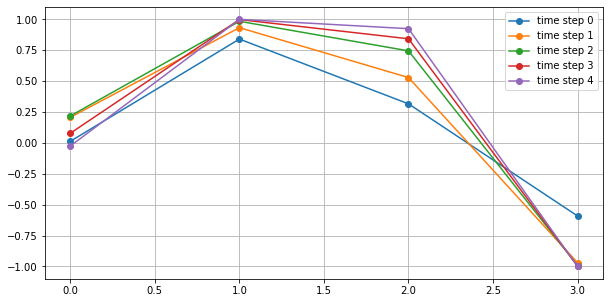

In [25]:
x_seq=tf.convert_to_tensor(
    [[1.*(i+1)]*inputs for i in range(m)],
    dtype=tf.float32)
compare_calc(rnn_layer74,x_seq)

In [26]:
model=tf.keras.Sequential(
    name='simple_rnn_structure')
model.add(tkl.Embedding(1000,32))
model.add(
    tkl.SimpleRNN(32,return_sequences=True))
model.add(tkl.SimpleRNN(32))
model.add(tkl.Dense(1))
model.summary()

Model: "simple_rnn_structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


In [27]:
model=tf.keras.Sequential(
    name='lstm_structure')
model.add(tkl.Embedding(10000,32))
model.add(
    tkl.LSTM(32,return_sequences=True))
model.add(tkl.LSTM(32))
model.add(tkl.Dense(1))
model.summary()

Model: "lstm_structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


In [28]:
model=tf.keras.Sequential(
    name='gru_structure')
model.add(tkl.Embedding(10000,32))
model.add(
    tkl.GRU(32,return_sequences=True))
model.add(tkl.GRU(32))
model.add(tkl.Dense(1))
model.summary()

Model: "gru_structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru (GRU)                    (None, None, 32)          6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 332,705
Trainable params: 332,705
Non-trainable params: 0
_________________________________________________________________


In [29]:
dhtml('Predicting Sentiments')

In [30]:
dhtml(' '.join(
    [list(token_counts)[i]
     for i in range(32)]),c2,f2,fs2)

In [31]:
embedding_dim=32
vocabulary_size=len(token_counts)+2
model=tf.keras.Sequential(
    name='bi_lstm_model')
model.add(tkl.Embedding(
    input_dim=vocabulary_size,
    output_dim=embedding_dim,
    name='embedding_layer'))
model.add(tkl.Bidirectional(
    tkl.LSTM(64,name='lstm_layer'),
    name='bidirect_lstm_layer'))
model.add(tkl.Dense(64,activation='relu',
                    name='dense_64'))
model.add(tkl.Dense(1,activation='sigmoid',
                    name='out'))
optimizer=tf.keras.optimizers.Adam(1e-3)
loss_fun=tf.keras.losses\
.BinaryCrossentropy(from_logits=False)
model.compile(
    optimizer=optimizer,loss=loss_fun,
    metrics=['accuracy'])

In [32]:
history=model.fit(
    train_data,epochs=5,
    validation_data=valid_data)

Epoch 1/5
932/932 [==============================] - 90s 97ms/step - loss: 0.4841 - accuracy: 0.7604 - val_loss: 0.6908 - val_accuracy: 0.5276
Epoch 2/5
932/932 [==============================] - 89s 95ms/step - loss: 0.6444 - accuracy: 0.6293 - val_loss: 0.6786 - val_accuracy: 0.5078
Epoch 3/5
932/932 [==============================] - 90s 97ms/step - loss: 0.4893 - accuracy: 0.7692 - val_loss: 0.4596 - val_accuracy: 0.7967
Epoch 4/5
932/932 [==============================] - 90s 97ms/step - loss: 0.4415 - accuracy: 0.8037 - val_loss: 0.4219 - val_accuracy: 0.8263
Epoch 5/5
932/932 [==============================] - 91s 97ms/step - loss: 0.3633 - accuracy: 0.8489 - val_loss: 0.3950 - val_accuracy: 0.8293


In [33]:
model.evaluate(test_data)

313/313 [==============================] - 14s 46ms/step - loss: 0.3933 - accuracy: 0.8281


[0.39330142736434937, 0.8281000256538391]

In [34]:
dhtml('Functions in Construction Process')

In [35]:
def preprocess_datasets(
    ds_train,ds_valid,ds_test,
    max_seq_len=None,batch_size=32):
    tokenizer=tfds.features.text.Tokenizer()
    token_counts=Counter()
    for ds in [ds_train,ds_valid,ds_test]:
        for example in ds:
            tokens=tokenizer.tokenize(
                example[0].numpy())
            if max_seq_len is not None:
                tokens=tokens[-max_seq_len:]
            token_counts.update(tokens)
    print('vocabulary size: ',len(token_counts))
    encoder=tfds.features.text\
    .TokenTextEncoder(token_counts)
    def encode(text_tensor,label):
        text=text_tensor.numpy()
        encoded_text=encoder.encode(text)
        if max_seq_len is not None:
            encoded_text=encoded_text[-max_seq_len:]
        return encoded_text,label
    def encode_fmap(text,label):
        return tf.py_function(
            encode,inp=[text,label], 
            Tout=(tf.int64,tf.int64))
    train=ds_train.map(encode_fmap)
    valid=ds_valid.map(encode_fmap)
    test=ds_test.map(encode_fmap)
    train_data=train.padded_batch(
        batch_size,padded_shapes=([-1],[]))
    valid_data=valid.padded_batch(
        batch_size,padded_shapes=([-1],[]))
    test_data=test.padded_batch(
        batch_size,padded_shapes=([-1],[]))
    return (train_data,valid_data,test_data,
            len(token_counts))

In [36]:
def build_rnn_model(
    embedding_dim,vocabulary_size,
    recurrent_type='SimpleRNN',
    n_rnn_units=64,n_rnn_layers=1,
    bidirect=True):
    tf.random.set_seed(123)
    model=tf.keras.Sequential()
    model.add(tkl.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        name='embedding_layer'))
    for i in range(n_rnn_layers):
        return_sequences=(i<n_rnn_layers-1)    
        if recurrent_type=='SimpleRNN':
            recurrent_layer=tkl.SimpleRNN(
                units=n_rnn_units, 
                return_sequences=return_sequences,
                name='simple_rnn_layer{}'.format(i))
        elif recurrent_type=='LSTM':
            recurrent_layer=tkl.LSTM(
                units=n_rnn_units, 
                return_sequences=return_sequences,
                name='lstm_layer{}'.format(i))
        elif recurrent_type=='GRU':
            recurrent_layer=tkl.GRU(
                units=n_rnn_units, 
                return_seq=return_sequences,
                name='gru_layer{}'.format(i))     
        if bidirect:
            recurrent_layer=tkl.Bidirectional(
                recurrent_layer,
                name='bidirect_'+recurrent_layer.name)       
        model.add(recurrent_layer)
    model.add(tkl.Dense(64,activation='relu'))
    model.add(tkl.Dense(1,activation='sigmoid'))
    return model

In [37]:
batch_size=32
max_seq_len=100
train_data,valid_data,test_data,n=\
preprocess_datasets(
    ds_train,ds_valid,ds_test,
    max_seq_len=max_seq_len,
    batch_size=batch_size)

vocabulary size:  9807


In [38]:
vocabulary_size=n+2
embedding_dim=32
rnn_model=build_rnn_model(
    embedding_dim,vocabulary_size,
    recurrent_type='SimpleRNN', 
    n_rnn_units=64,n_rnn_layers=3,
    bidirect=True)
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, None, 32)          313888    
_________________________________________________________________
bidirect_simple_rnn_layer0 ( (None, None, 128)         12416     
_________________________________________________________________
bidirect_simple_rnn_layer1 ( (None, None, 128)         24704     
_________________________________________________________________
bidirect_simple_rnn_layer2 ( (None, 128)               24704     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 384,033
Trainable params: 384,033
Non-trainable params: 0
__________________________________________________

In [39]:
optimizer=tf.keras.optimizers.Adam(1e-3)
loss_fun=tf.keras.losses\
.BinaryCrossentropy(from_logits=False)
rnn_model.compile(
    optimizer=optimizer,loss=loss_fun,
    metrics=['accuracy'])
history=rnn_model.fit(
    train_data,epochs=10,
    validation_data=valid_data)

Epoch 1/10
932/932 [==============================] - 454s 487ms/step - loss: 0.6850 - accuracy: 0.5547 - val_loss: 0.6057 - val_accuracy: 0.6639
Epoch 2/10
932/932 [==============================] - 454s 488ms/step - loss: 0.4941 - accuracy: 0.7648 - val_loss: 0.5216 - val_accuracy: 0.7365
Epoch 3/10
932/932 [==============================] - 458s 492ms/step - loss: 0.3839 - accuracy: 0.8381 - val_loss: 0.4598 - val_accuracy: 0.8034
Epoch 4/10
932/932 [==============================] - 445s 478ms/step - loss: 0.3268 - accuracy: 0.8669 - val_loss: 0.4527 - val_accuracy: 0.8151
Epoch 5/10
932/932 [==============================] - 435s 467ms/step - loss: 0.3186 - accuracy: 0.8676 - val_loss: 0.5388 - val_accuracy: 0.7560
Epoch 6/10
932/932 [==============================] - 435s 466ms/step - loss: 0.3051 - accuracy: 0.8750 - val_loss: 0.4937 - val_accuracy: 0.8024
Epoch 7/10
932/932 [==============================] - 451s 484ms/step - loss: 0.2700 - accuracy: 0.8992 - val_loss: 0.5131 -

In [40]:
rnn_model.evaluate(test_data)

313/313 [==============================] - 20s 64ms/step - loss: 0.5727 - accuracy: 0.7628


[0.5726845264434814, 0.7627999782562256]